# Festival Data Analysis 

## Pull Data from GCP

SQL_Query = SELECT * FROM tmint-ci-interview.sample_dataset.sample_data;

## Import Libraries 

In [1]:
#import necessary libraries 

import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.cluster import KMeans

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler

## Import data from local 

In [2]:
#import dataset

dataset = pd.read_csv('~/Desktop/bq-results-20210206-104302-mhndx9vrkh15.csv')

## Preliminary Analysis and Data Cleaning

In [3]:
#indentify number of unique orders

dataset['customer_id'].nunique()

433

In [4]:
#keep only first order, sorted by date

dataset.sort_values(by=['order_date'], inplace=True)

dataset.drop_duplicates(subset='customer_id', keep='first', inplace=True)

In [5]:
#visualise table

dataset.head()

,order_id,customer_id,event_onsale_date,order_date,ticket_type,ticket_level,payment_type,customer_age_band,ticket_qty,ticket_value,customer_previous_purchase_flag,customer_previous_purchase_festival_flag,customer_previous_purchase_music_flag,customer_previous_purchase_theatre_flag,customer_previous_purchase_sport_flag
370,39,1039,1997-01-01,1997-01-01,Camping,P2,Full,30-40,1,78.75,1,0,1,0,0
387,45,1045,1997-01-01,1997-01-01,Camping,P2,Full,40-50,2,157.50,1,1,1,0,0
385,34,1034,1997-01-01,1997-01-01,Camping,P2,Full,40-50,2,157.50,1,1,0,0,0
384,15,1015,1997-01-01,1997-01-01,Camping,P2,Full,15-20,1,78.75,1,1,0,0,0
383,40,1040,1997-01-01,1997-01-01,Camping,P2,Installment,15-20,1,78.75,1,1,1,0,0


<AxesSubplot:xlabel='customer_age_band'>

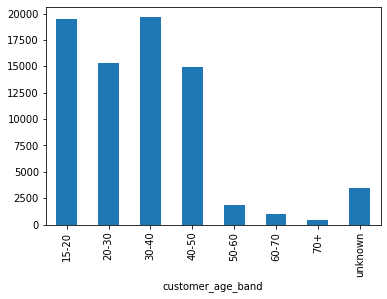

In [6]:
#exploring distribution of revenue over different age bands 

dataset.groupby(['customer_age_band'])['ticket_value'].sum().plot(kind='bar')

<AxesSubplot:xlabel='customer_age_band'>

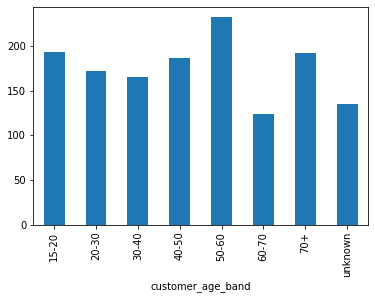

In [7]:
#exploring average spend per order over different age bands

dataset.groupby(['customer_age_band'])['ticket_value'].mean().plot(kind='bar')

Looking at the above two graphs, we can see that the majority of revenue comes from 15-50 age bands. However, the highest spenders per order we 50-60. The spread in terms of the ages of people who you would typically expect at a festival 15-50, is surprisingly even.

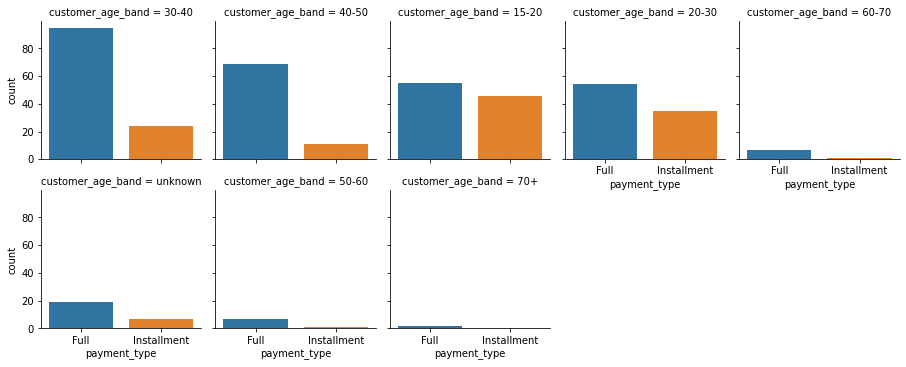

In [8]:
#type of payment by customer age band

new_var=dataset[['payment_type', 'customer_age_band']]
sns.catplot('payment_type', col='customer_age_band', data=new_var, kind='count', height=2.5, aspect=1, col_wrap=5)

In [9]:
#average number of tickets bought per order grouped by previous festival vs no previous festival
#about 50% increase in number of tickets per order

dataset.groupby(['customer_previous_purchase_festival_flag'])['ticket_qty'].mean()

customer_previous_purchase_festival_flag
0    2.674157
1    1.875000
Name: ticket_qty, dtype: float64

In [10]:
#day vs camping grouped by previous festival vs no previous festival

dataset.groupby(['customer_previous_purchase_festival_flag', 'ticket_type'])['customer_id'].count()

customer_previous_purchase_festival_flag  ticket_type
0                                         Camping         41
                                          Day             48
1                                         Camping        184
                                          Day            160
Name: customer_id, dtype: int64

In [11]:
_1997 = dataset.groupby(['event_onsale_date'])['ticket_qty'].sum()[0]
_1998 = dataset.groupby(['event_onsale_date'])['ticket_qty'].sum()[1]
_1999 = dataset.groupby(['event_onsale_date'])['ticket_qty'].sum()[2]
pct_change1 = ((_1998 - _1997) / _1997) * 100
pct_change2 = ((_1999 - _1998) / _1998) * 100

In [12]:
pct_change1

-48.842592592592595

In [13]:
pct_change2

4.072398190045249

<AxesSubplot:xlabel='event_onsale_date'>

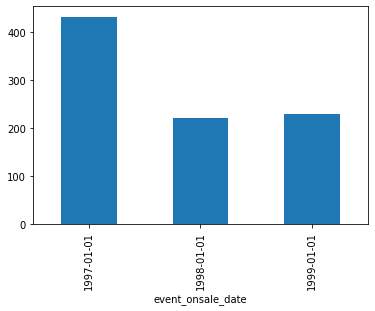

In [14]:
#number of tickets sold per year

dataset.groupby(['event_onsale_date'])['ticket_qty'].sum().plot(kind='bar')



<AxesSubplot:xlabel='event_onsale_date'>

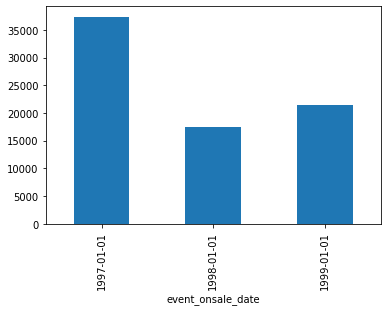

In [15]:
#revenue per year

dataset.groupby(['event_onsale_date'])['ticket_value'].sum().plot(kind='bar')

In [16]:
#average revenue per order across three different years

dataset.groupby('event_onsale_date')['ticket_value'].sum() / dataset.groupby('event_onsale_date')['ticket_qty'].count()

event_onsale_date
1997-01-01    186.693750
1998-01-01    135.009690
1999-01-01    205.408654
dtype: float64

<AxesSubplot:xlabel='order_date'>

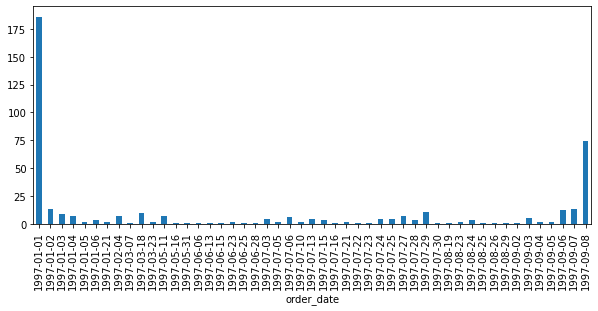

In [17]:
dataset.loc[dataset['event_onsale_date']=='1997-01-01'].groupby('order_date')['ticket_qty'].sum().plot(kind='bar', figsize=(10,4))

<AxesSubplot:xlabel='order_date'>

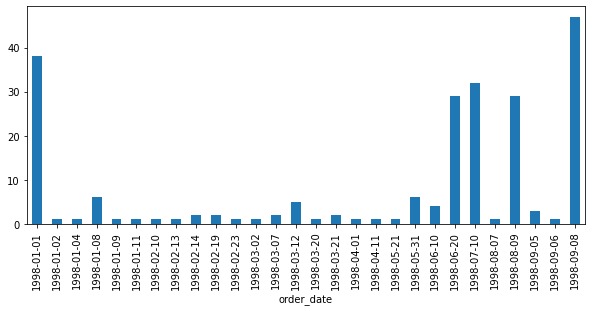

In [18]:
dataset.loc[dataset['event_onsale_date']=='1998-01-01'].groupby('order_date')['ticket_qty'].sum().plot(kind='bar', figsize=(10,4))

<AxesSubplot:xlabel='order_date'>

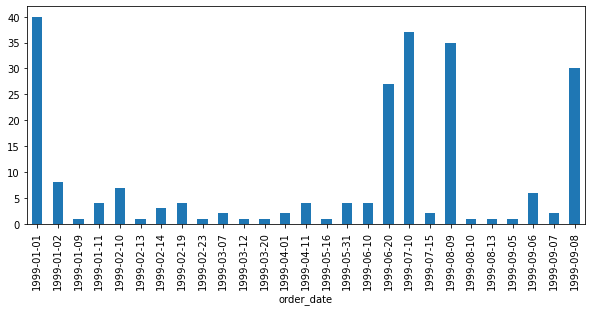

In [19]:
dataset.loc[dataset['event_onsale_date']=='1999-01-01'].groupby('order_date')['ticket_qty'].sum().plot(kind='bar', figsize=(10,4))

## Cluster Analysis

#### Data Preprocessing 

In [20]:
#drop columns that cant be scaled or that offer no information

dataset.drop(['event_onsale_date', 'order_id', 'customer_id', 'order_date'], axis=1, inplace=True)

categoricals = ['ticket_type', 'ticket_level', 'customer_age_band', 'payment_type']

dataset_encoded = dataset.copy()

#label encoding for categorical features

labelencoder=LabelEncoder()
for column in categoricals:
    dataset_encoded[column] = labelencoder.fit_transform(dataset_encoded[column])

#### Scaling Features

In [21]:
#instantiate scaler class

scaler = StandardScaler()

#fit scaler to data

scaler.fit(dataset_encoded)

#transform data 

scaled_features = scaler.transform(dataset_encoded)

#load scaled data into dataframe

scaled_data = pd.DataFrame(scaled_features, columns = dataset_encoded.columns)

#visualising scaled data in table

scaled_data

,ticket_type,ticket_level,payment_type,customer_age_band,ticket_qty,ticket_value,customer_previous_purchase_flag,customer_previous_purchase_festival_flag,customer_previous_purchase_music_flag,customer_previous_purchase_theatre_flag,customer_previous_purchase_sport_flag
0,-0.961480,0.755588,-0.637059,0.043059,-0.623154,-0.605480,0.361315,-1.966003,1.152370,-0.153755,-0.242239
1,-0.961480,0.755588,-0.637059,0.608043,-0.023541,-0.114125,0.361315,0.508646,1.152370,-0.153755,-0.242239
2,-0.961480,0.755588,-0.637059,0.608043,-0.023541,-0.114125,0.361315,0.508646,-0.867777,-0.153755,-0.242239
3,-0.961480,0.755588,-0.637059,-1.086910,-0.623154,-0.605480,0.361315,0.508646,-0.867777,-0.153755,-0.242239
4,-0.961480,0.755588,1.569713,-1.086910,-0.623154,-0.605480,0.361315,0.508646,1.152370,-0.153755,-0.242239
...,...,...,...,...,...,...,...,...,...,...,...
428,1.040063,2.256367,-0.637059,0.043059,-0.023541,0.275839,0.361315,0.508646,-0.867777,-0.153755,-0.242239
429,1.040063,-0.745190,-0.637059,-1.086910,-0.623154,-0.660075,0.361315,0.508646,-0.867777,-0.153755,-0.242239
430,1.040063,-0.745190,-0.637059,0.043059,-0.023541,-0.223315,0.361315,0.508646,-0.867777,-0.153755,-0.242239
431,1.040063,-0.745190,-0.637059,0.043059,-0.623154,-0.660075,0.361315,0.508646,1.152370,-0.153755,-0.242239


In [22]:
#instantiate kmeans model class with 6 clusters. 

kmeans = KMeans(init="random", n_clusters=6, n_init=10, max_iter=300, random_state=42)

In [23]:
# Convert DataFrame to matrix
mat = scaled_data.values

#fit scaled data to model

kmeans.fit(mat)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=6,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=42,
       tol=0.0001, verbose=0)

In [24]:
#make clusters a column in dataframe

dataset['cluster'] = kmeans.labels_ 

In [25]:
#average order value and number of tickets for each cluster

dataset.groupby('cluster')['ticket_value','ticket_qty'].mean()

,ticket_value,ticket_qty
cluster,,
0,144.125000,1.600000
1,198.776596,2.574468
2,145.105634,1.450704
3,130.789474,1.557895
4,589.572368,6.210526
5,98.019802,1.544554


In [26]:
#average revenue per ticket

dataset.groupby('cluster')['ticket_value'].sum() / dataset.groupby('cluster')['ticket_qty'].sum()

cluster
0     90.078125
1     77.210744
2    100.024272
3     83.952703
4     94.931144
5     63.461538
dtype: float64

In [27]:
#number of orders in each cluster

dataset.groupby('cluster')['ticket_qty'].count()

cluster
0     10
1     47
2    142
3     95
4     38
5    101
Name: ticket_qty, dtype: int64

In [28]:
#total revenue per cluster 

dataset.groupby('cluster')['ticket_value'].sum()

cluster
0     1441.25
1     9342.50
2    20605.00
3    12425.00
4    22403.75
5     9900.00
Name: ticket_value, dtype: float64

## Analysing best and worst performing clusters

In [29]:
#taking only the best and worst performing clusters by total revenue, average order revenue and ticket quantity.

dataset_top_bottom = dataset.loc[dataset['cluster'] > 3]

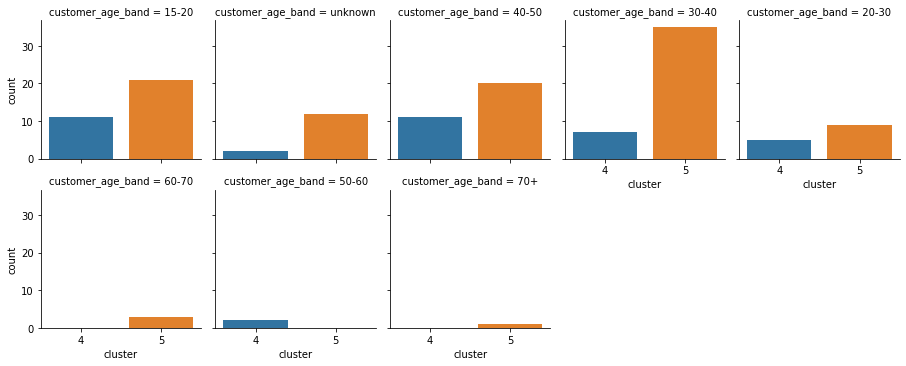

In [30]:
new_var=dataset_top_bottom[['cluster', 'customer_age_band']]
sns.catplot('cluster', col='customer_age_band', data=new_var, kind='count', height=2.5, aspect=1, col_wrap=5)

<AxesSubplot:>

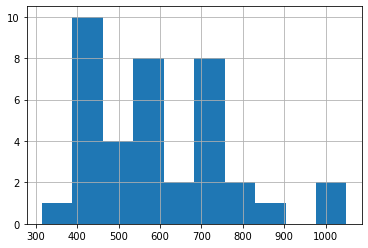

In [31]:
#distribution of spend per order for cluster 4

dataset.loc[dataset['cluster'] ==4]['ticket_value'].hist()

<AxesSubplot:>

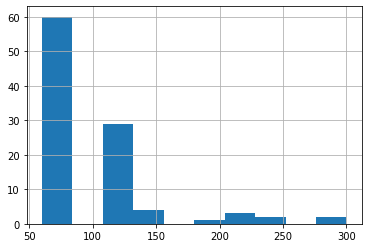

In [32]:
#distribution of spend per order for cluster 5

dataset.loc[dataset['cluster'] ==5]['ticket_value'].hist()

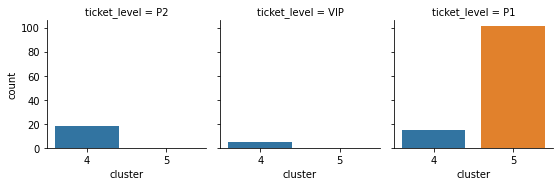

In [33]:
#exploring ticket levels in the two clusters

new_var=dataset_top_bottom[['cluster', 'ticket_level']]
sns.catplot('cluster', col='ticket_level', data=new_var, kind='count', height=2.5, aspect=1, col_wrap=5)

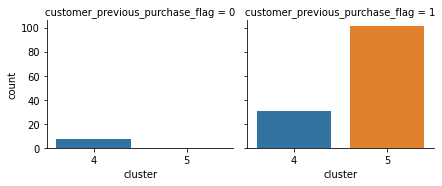

In [34]:
#previous purchase flag in clusters

new_var=dataset_top_bottom[['cluster', 'customer_previous_purchase_flag']]
sns.catplot('cluster', col='customer_previous_purchase_flag', data=new_var, kind='count', height=2.5, aspect=1.15, col_wrap=5)

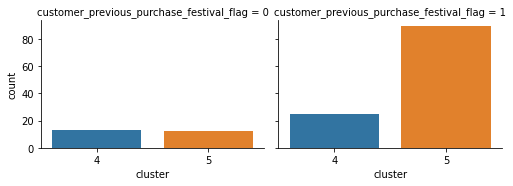

In [35]:
#exploring festival purchase flag in clusters

new_var=dataset_top_bottom[['cluster', 'customer_previous_purchase_festival_flag']]
sns.catplot('cluster', col='customer_previous_purchase_festival_flag', data=new_var, kind='count', height=2.5, aspect=1.35, col_wrap=5)



# Insights 

1. Looking at how ticket purchases are distributed over time - most are bought at the start and the end of each time series for each year of the festival. Assumption that this corresponds to start of sales and start of festival. If festival tickets are not selling out, how can we sustain interest during the months inbetween ticket launch and the event itself? 

2. Looking at your most valuable and least valuable customers by revenue. Who are they. 

Cluster 5 "Low spenders" - lowest total revenue and lowest revenue per order
- all bought P1 tickets
- 1.5 tickets bought on average per order
- all had previous purchases with ticket master 
- much greater proportion had previous ticket purchase than cluster 4

Cluster 4 "Big Spenders"- highest total revenue and highest revenue per order
- less than half bought P1 tickets, maybe 10/50 bought VIP, the rest were p2 
- on average bought 6 tickets per order
- circa 20% had not bought anything on Ticket Master previously. 

Conclusions for point 2: Big spenders not only bought the most tickets but they bought on average the second most expensive tickets. 

Who are these people? 

Big Spenders - Organisers, perhaps people who organise a motivate a group. 

Low Spenders: These are customers that have bought with Ticket Master before, so we may have more data. How can we entice them to come back? Multi-ticket deals could be an option?

3. Ticket sales went down pretty drastically from 1997 to 1998, down 48% and back up marginally by 4% in 1999, revenue naturally reflected similar changes. 

Has the size of the festival changed? Are there other factors at play? 

Extra points

1. 50-60 age bracket very small proportion of total revenue but were highest spenders per order
2. Installment tickets were far more popular with the 15-30 age bands than the rest. 
3. Customers who had not previously bought a festival ticket on average bought 50% more tickets per order
4. Error in data to point out: some customers have been flagged as no previous purchase but have also been flagged as having a previous festival purchase. 

Datapoints I would like to see

1. Were the festivals sold out? Was there spare capacity in VIP tickets for example?
2. Estimates for festival life value of Day/Camping customers and VIP vs regular
3. Is it possibile to track spending - QR code bracelet for instance, this might allow us to track who are the true highest value customers overall.